In [1]:
from exp.utils import *
from exp.models import *
from tqdm.notebook import tqdm
from multiprocessing import Pool

import torch
import torch.nn as NN
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

In [2]:
seed = 92
seed_everything(seed)

In [3]:
model_name = "py_test_pneumonia_01"
bs = 16
epochs = 5
image_size = (228, 228)
device = get_device()
lr = 3e-3

Using the GPU!


In [4]:
sigmoid = NN.Sigmoid()

In [5]:
#labels = ["Pneumonia"]
labels = get_labels()

In [6]:
train_df, valid_df, test_df = get_dataframes(include_labels=labels, small=False)
train_df.shape, valid_df.shape, test_df.shape

/home/favi/work/crx8/exp/utils.py:161: UserWarning: Train-Val-Split currently with patient overlap!
  warnings.warn("Train-Val-Split currently with patient overlap!")


((69219, 24), (17305, 24), (25596, 24))

In [ ]:
tr, te = get_label_dfs()

In [45]:
LABEL_DF

,Image Index,Hernia,Effusion,Infiltration,Mass,Nodule,Atelectasis,Pneumonia,Consolidation,Emphysema,...,Cardiomegaly,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,2,80,M,PA,2500,2048,0.171,0.171
12,00000004_000.png,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0,4,82,M,AP,2500,2048,0.168,0.168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112113,00030800_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,30800,33,F,PA,2048,2500,0.168,0.168
112116,00030802_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,30802,28,M,PA,2048,2500,0.168,0.168
112117,00030803_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,30803,42,F,PA,2048,2500,0.168,0.168
112118,00030804_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,30804,29,F,PA,2048,2500,0.168,0.168


In [50]:
LABEL_DF = None

In [51]:
def load_label_df():
    global LABEL_DF
    if LABEL_DF is None: 
        LABEL_DF = pd.read_csv(get_data_path()/"Data_Entry_2017_v2020.csv")
        to_drop = [c for c in LABEL_DF.columns if c not in ["Image Index", "Finding Labels"]]
        LABEL_DF = LABEL_DF.drop(columns=to_drop)
    return LABEL_DF

In [49]:
data = pd.read_csv(get_data_path()/"Data_Entry_2017_v2020.csv")
to_drop = [c for c in data.columns if c not in ["Image Index", "Finding Labels"]]
data = data.drop(columns=to_drop)

data

,Image Index,Finding Labels
0,00000001_000.png,Cardiomegaly
1,00000001_001.png,Cardiomegaly|Emphysema
2,00000001_002.png,Cardiomegaly|Effusion
3,00000002_000.png,No Finding
4,00000003_001.png,Hernia
...,...,...
112115,00030801_001.png,Mass|Pneumonia
112116,00030802_000.png,No Finding
112117,00030803_000.png,No Finding
112118,00030804_000.png,No Finding


In [10]:
tete = pd.read_csv(get_data_path()/"Data_Entry_2017_v2020.csv")
comp = pd.concat([train_df, valid_df, test_df], axis=0)

In [52]:
def image2label(fn):
    label_df = load_label_df()
    return label_df[label_df["Image Index"] == fn]["Finding Labels"]

In [53]:
def translate2label(arr, labels=None):
    arr = arr.values[0]
    print(arr.shape)
    if labels is None: labels = get_labels()
    idx2lbl = {i: l for i, l in enumerate(labels)}
    pos_lbls = [idx2lbl[idx] for idx, v in enumerate(arr) if v == 1]
    print(pos_lbls)
    if len(pos_lbls) == 0: return "No Finding"
    return "|".join(pos_lbls)

Label before: Atelectasis
(14,)
['Atelectasis']
label after: Atelectasis


,Hernia,Effusion,Infiltration,Mass,Nodule,Atelectasis,Pneumonia,Consolidation,Emphysema,Fibrosis,Pneumothorax,Pleural_Thickening,Edema,Cardiomegaly
75938,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


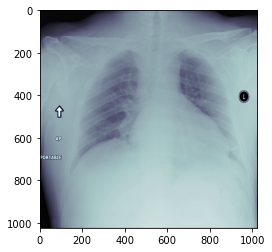

In [57]:
idx = np.random.choice(tete.shape[0])
rand_im = tete.iloc[idx, 0]
show_image(get_image_path()/rand_im)
print("Label before:", tete.iloc[idx, 1])

abc = comp[comp["Image Index"] == rand_im][labels]
print("label after:", translate2label(abc))
abc

In [20]:
comp

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],...,Nodule,Atelectasis,Pneumonia,Consolidation,Emphysema,Fibrosis,Pneumothorax,Pleural_Thickening,Edema,Cardiomegaly
1705,00000459_057.png,30,459,55,F,PA,2698,2845,0.143000,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87289,00021552_011.png,24,21552,53,M,PA,2021,2021,0.194311,0.194311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73238,00018029_000.png,0,18029,66,M,PA,2870,2991,0.143000,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1564,00000416_005.png,5,416,67,F,PA,2992,2991,0.143000,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
67357,00016630_011.png,10,16630,30,M,AP,2500,2048,0.168000,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112113,00030800_000.png,0,30800,33,F,PA,2048,2500,0.168000,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112116,00030802_000.png,0,30802,28,M,PA,2048,2500,0.168000,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112117,00030803_000.png,0,30803,42,F,PA,2048,2500,0.168000,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112118,00030804_000.png,0,30804,29,F,PA,2048,2500,0.168000,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_label = train_df[labels].values
pos_weights = compute_positive_class_weigths(train_label)

In [ ]:
train_tfs = transforms.Compose([
    transforms.Normalize([SUBSET_MEAN]*3, [SUBSET_STD]*3),
    #transforms.RandomHorizontalFlip(p=0.5)
])
test_tfs = transforms.Compose([
    transforms.Normalize([SUBSET_MEAN]*3, [SUBSET_STD]*3),
    
])

In [ ]:
train_ds = CRX8_Data(train_df, get_image_path(), labels, image_size=image_size, transforms=train_tfs)
valid_ds = CRX8_Data(valid_df, get_image_path(), labels, image_size=image_size, transforms=test_tfs)
test_ds  = CRX8_Data(test_df , get_image_path(), labels, image_size=image_size, transforms=test_tfs)

In [ ]:
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size=bs, shuffle=False)

dataloaders = {
    "train": train_dl,
    "val": valid_dl,
    "test": test_dl
}

In [ ]:
#export
def show_image(fn):
    im = plt_image.imread(fn)
    plt.imshow(im, cmap="bone");

In [ ]:
dd = train_df[train_df["Hernia"] ]

In [ ]:
i = 0
fn = train_df["Image Index"].iloc[i]
display(train_df.iloc[i].loc[labels])
print(translate2label(train_df[labels].iloc[i]))
show_image(get_image_path()/fn)

In [ ]:
X, y = get_batch(10, train_dl)
print_batch(X, y)

In [ ]:
criterion = NN.BCEWithLogitsLoss(pos_weight=pos_weights.to(device), reduction="sum")

In [ ]:
model = pretrained_densenet121(labels=labels)
model = model.to(device)

In [ ]:
#export
def transfer_learn_setup(model, modelname, lr):
    if "densenet" in modelname.lower():
        return torch.optim.Adam(model.classifier.parameters(),lr=lr)
    elif "resnet" in modelname.lower():
        return torch.optim.Adam(model.fc.parameters(),lr=lr)

#export
def fine_tune_setup(model, lr):
    return torch.optim.Adam(model.parameters(),lr=lr)

In [ ]:
transfer_optimizer = transfer_learn_setup(model, "densenet", lr)

In [ ]:
layers = get_layers(model)
f"Last layer: {layers[-1][1]}"

In [ ]:
#optimizer = torch.optim.Adam(model.parameters(),lr=lr)

In [ ]:
logs,losses = find_lr(model, train_dl, transfer_optimizer, criterion, device=device)
i = 10
plt.plot(logs[i:-i],losses[i:-i]);

In [ ]:
lr = 3e-5

In [ ]:
transfer_optimizer = transfer_learn_setup(model, "densenet", lr)

In [ ]:
logger = Logger()
logger.add_metric("loss")
logger.add_metric("acc")
logger.add_metric("auroc")

In [ ]:
num_steps = len(train_dl)
lr_range = (lr / 10, lr)
scheduler = OneCycleLR(transfer_optimizer, num_steps, lr_range)

In [ ]:
model = train_model(model, criterion, transfer_optimizer, scheduler, 
                    dataloaders, logger, model_name, labels=labels,
                    num_epochs=epochs, device=device)

In [ ]:
logger.plot_losses()

In [ ]:
logger.plot_acc()

In [ ]:
logger.plot_auroc()

In [ ]:
logger.state["val_auroc"][4][0].mean()

In [ ]:
fine_optimizer = fine_tune_setup(model, lr)

In [ ]:
#logs,losses = find_lr(model, train_dl, fine_optimizer, criterion, device=device)
i = 1
plt.plot(logs[i:-i],losses[i:-i]);

In [ ]:
lr = 1e-4

In [ ]:
fine_optimizer = fine_tune_setup(model, lr)
num_steps = len(train_dl)
lr_range = (lr / 10, lr)
scheduler = OneCycleLR(fine_optimizer, num_steps, lr_range)

In [ ]:
model = train_model(model, criterion, fine_optimizer, scheduler, 
                    dataloaders, logger, model_name, labels=labels,
                    num_epochs=epochs, device=device)

In [ ]:
logger.plot_losses()

In [ ]:
logger.plot_acc()

In [ ]:
logger.plot_auroc()

In [ ]:
X, y = get_batch(0, train_dl)

In [ ]:
#export
def print_batch(X, y):
    assert X.shape[0] % 2 == 0
    X = X * SUBSET_STD + SUBSET_MEAN
    x_dim = int(X.shape[0] / 2)
    y_dim = int(X.shape[0] / x_dim)
    
    axes = []
    figure = plt.figure(figsize=(2*x_dim, 20*y_dim))
    i = 0
    for y_idx in range(y_dim):
        for x_idx in range(x_dim):
            axes.append(figure.add_subplot(x_dim, y_dim, i+1))
            axes[-1].set_title(translate2label(y[i]))
            plt.imshow(X[i].reshape(X[i].shape[1], X[i].shape[2], X[i].shape[0]))
            i += 1
    figure.tight_layout()
    plt.show()

In [ ]:
#export
class CRX8_Data(Dataset):
    
    def __init__(self, df, image_path, labels, image_size=None, transforms=None):
        self.df = df
        self.image_size = image_size
        #if image_size is not None:
        #    self.resizer = transforms.Resize(image_size)
        self.image_path = image_path
        self.len = df.shape[0]
        self.labels = labels
        self.transforms = transforms
        self.df["Index_2"] = list(range(self.df.shape[0]))
        
    def __len__(self): return self.len
    
    def _resize(self, im):
        return transforms.Resize(self.image_size)(im)

    def __getitem__(self, idx):
        img_path = self._get_image_path(idx)     
        image = read_image(img_path)
        if self.image_size is not None: image = self._resize(image)
        image = self._make3D(image)
        label = self.df.iloc[idx,:].loc[self.labels].values
        if self.transforms: image = self.transforms(image)

        return image.float(), torch.Tensor(label.astype(np.float)).float()
    
    def _make3D(self, t):
        reshaped = np.repeat(t[0,:,:].float(), 3).view(3, t.shape[1], t.shape[2])
        reshaped /= 255.
        return reshaped
    
    def _get_image_path(self, idx):
        return str(self.image_path/self.df.iloc[idx].loc["Image Index"]) 

In [ ]:
train_ds = CRX8_Data(train_df, get_image_path(), labels, image_size=image_size, transforms=train_tfs)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

In [ ]:
array_info(im, with_hist=False)

In [ ]:
im = read_image(train_ds._get_image_path(0))
#im = train_ds.__getitem__(0)[0]
print(im.shape)
#im = (im + 2)/4
plt.imshow(im.reshape(im.shape[1], im.shape[2], im.shape[0]), cmap="gray");
#plt.imshow(im, cmap="gray");

In [ ]:
im = transforms.Resize(image_size)(im)
plt.imshow(im.reshape(im.shape[1], im.shape[2], im.shape[0]), cmap="gray");

In [ ]:
im = train_ds._make3D(im)
print(im.shape)
im = transforms.Resize(image_size)(im.reshape(im.shape[1], im.shape[2], im.shape[0]))
im = im.reshape(im.shape[1], im.shape[2], im.shape[0])
print(im.shape)
plt.imshow(im.reshape(im.shape[1], im.shape[2], im.shape[0]), cmap="gray");

In [ ]:
print_image(*train_ds.__getitem__(0))

In [ ]:
print_image(X[0], y[0])

In [ ]:
print_batch(X, y)

In [ ]:
#export
def get_batch(idx, dl):
    assert idx < len(dl)
    for i, data in enumerate(dl):
        if i == idx: return data

In [ ]:
df, _, _ = get_dataframes(small=True, small_fraction=0.5, include_labels=labels)

In [ ]:
df.shape

In [ ]:
df

In [ ]:
labels = ["Effusion", "Hernia"]

In [ ]:
df[df[labels].sum(axis=1, numeric_only=True) > 0]

In [ ]:
#df[df[labels].sum(axis=1, numeric_only=True) > 0]